In [1]:
import pandas as pd

In [2]:
df_hsk = pd.concat(
    (
        pd.read_csv(f"data/hsk{i}.csv", names=["simplified", "pinyin", "meanings"])
        .assign(level=i)
    )
    for i in range(1,7)
)[["simplified", "pinyin", "meanings", "level"]]

In [3]:
def vowelsToTone(pinyin):
    accentMap = {
        "a": ["ā", "á", "ǎ", "à"],  #, "a"],
        "A": ["Ā", "Á", "Ǎ", "À"],  #, "A"],
        "e": ["ē", "é", "ě", "è"],  #, "e"],
        "E": ["Ē", "É", "Ě", "È"],  #, "E"],
        "i": ["ī", "í", "ǐ", "ì"],  #, "i"],
        "I": ["Ī", "Í", "Ǐ", "Ì"],  #, "I"],
        "o": ["ō", "ó", "ǒ", "ò"],  #, "o"],
        "O": ["Ō", "Ó", "Ǒ", "Ò"],  #, "o"],
        "u": ["ū", "ú", "ǔ", "ù"],  #, "u"],
        "U": ["Ū", "Ú", "Ǔ", "Ù"],  #, "u"],
        "v": ["ǖ", "ǘ", "ǚ", "ǜ"],  #, "ü"],
        "V": ["Ǖ", "Ǘ", "Ǚ", "Ǜ"],  #, "Ü"],
    }
    def vowelToTone(word):
        for noAccent, accents in accentMap.items():
            for i, accent in enumerate(accents):
                if accent in word:
                    return f"{word.replace(accent, noAccent)}{i+1}"
        return f"{word}5"
        
    return " ".join(vowelToTone(x) for x in pinyin.split(" "))

df_hsk = df_hsk.assign(pinyin=df_hsk["pinyin"].map(vowelsToTone))
df_hsk

,simplified,pinyin,meanings,level
0,爱,ai4,to love,1
1,八,ba1,eight,1
2,爸爸,ba4 ba5,(informal) father,1
3,杯子,bei1 zi5,cup,1
4,北京,Bei3 jing1,Beijing,1
...,...,...,...,...
2495,座右铭,zuo4 you4 ming2,motto,6
2496,作弊,zuo4 bi4,to practice fraud,6
2497,作废,zuo4 fei4,to become invalid,6
2498,作风,zuo4 feng1,style,6


In [4]:
# https://github.com/mike-fabian/ibus-table-chinese/blob/main/tables/
df_cj = pd.read_csv(
#     "data/cangjie5.txt",
    "data/cangjie-big.txt",
    comment="#",
    sep="\t",
    quoting=3,  # csv.QUOTE_NONE
#     skiprows=148,
    skiprows=160,
    skipfooter=2,
    keep_default_na=False,
    names=["cangjie", "hanzi", "noidea"],
)[["hanzi", "cangjie"]]

df_cj = (
    df_cj
    .assign(
        hanzi=df_cj["hanzi"].astype("string"),
        cangjie=df_cj["cangjie"].astype("string")
    )
    .groupby("hanzi")
    .agg("first")  # first is fine because the only duplicates are weird symbols
)

/var/folders/q1/w0s_n4x93y30t1tf6m9x42rw0000gn/T/ipykernel_70543/3080385304.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df_cj = pd.read_csv(


In [5]:
df_wb = pd.read_csv(
    "data/wubi-haifeng86.UTF-8",
    comment="#",
    sep="\t",
    quoting=3,  # csv.QUOTE_NONE
    skiprows=0,
    skipfooter=0,
    keep_default_na=False,
    names=["wubi", "hanzi", "noidea"],
)[["hanzi", "wubi"]]

# not sure what len(hanzi)>1 means when it has a full stop, but just remove
df_wb = df_wb[df_wb["hanzi"].map(len).eq(1)]#.groupby("hanzi").agg({"wubi": lambda x: " ".join(x)})
df_wb = (
    df_wb
    .assign(
        hanzi=df_wb["hanzi"].astype("string"),
        wubi=df_wb["wubi"].astype("string")
    )
    .groupby("hanzi")
    # there are many ways to type the same zi but choose the shortest one for our purposes
    .agg(lambda x: min(sorted(x), key=len))
)

In [44]:
df_hsk["level"].value_counts()

6    2500
5    1300
4     601
3     299
1     150
2     150
Name: level, dtype: int64

In [176]:
hsk_levels = {1,2,3}
# df_hsk["simplified"].str.split("")
words = df_hsk[df_hsk["level"].isin(hsk_levels)]["simplified"]
zi_set = set(''.join(words))
len(zi_set)

618

In [177]:
df_hier = df_cj[df_cj.index.isin(zi_set)].join(df_wb, how="inner")

assert len(df_hier) == len(zi_set)
assert sum(df_hier["cangjie"].str.contains(" ")) == 0
assert sum(df_hier["wubi"].str.contains(" ")) == 0

df_hier

,cangjie,wubi
hanzi,,
一,m,g
七,jv,ag
万,ms,dnv
丈,jk,dyi
三,mmm,dg
...,...,...
鸟,hsim,qyng
鸡,ehsm,cqy
黄,twc,amw


hierarchy needs a placement for leaves and branches
for cangjie we can just use alphabetical order for positioning nodes
                 abcdefghijklmnopqrstuvwxyz
for wubi we want gfdsahjklmtrewqyuiopnbvcxz

but what about when there is a ab abc, where a and b are both branch and leaf?
I think the cleanest is something like:
     a
    / \
   .   b
   |  / \
   . .   c

this keeps the layout planar
if there is a long line of single children then we can consider only keeping the first single parent with the leaf
I don't think we have enough layers for this to be a big issue though

In [178]:
import networkx as nx
import math
import numpy as np
import functools
from collections import defaultdict

In [179]:
def construct_dual_graph(spellings: pd.Series, words: pd.Series, pad=False):
    trie = nx.DiGraph()
    root = trie.add_node("")

    if pad:
        spellings = spellings.str.pad(spellings.map(len).max(), "right")
    
    for zi, spelling in spellings.items():
        trie.add_edge("", spelling[0], duality="hierarchy")
        for i in range(len(spelling) - 2):
            trie.add_edge(spelling[:i+1], spelling[:i+2], duality="hierarchy")
        trie.add_edge(spelling[:-1], zi, duality="hierarchy")
        trie.nodes[zi]["leaf"] = True
    
    # checks if it is a tree
    assert nx.is_arborescence(trie)
    
    # add reference to parent for easier LCA calc
    for source, target in list(trie.edges):
        trie.nodes[target]["parent"] = source
        
    for _, word in words.items():
        for i in range(len(word) - 1):
            source, target = word[i:i+2]
            trie.add_edge(source, target, duality="adjacency")
            
    return trie

In [180]:
trie = construct_dual_graph(df_hier["cangjie"], words)

In [181]:
POLAR_DISTANCE_GAMMA = lambda x: x
# POLAR_DISTANCE_GAMMA = math.sqrt
# POLAR_DISTANCE_GAMMA = lambda x: x**2

SORT_ORDER = lambda x: x
# WUBI_ORDER = {v:i for i, v in enumerate("gfdsahjklmtrewqyuiopnbvcxz")}; SORT_ORDER = lambda x: WUBI_ORDER.get(x[-1], 1)

def radial_layout(trie: nx.DiGraph, parent: str, depth: int, leaf_i: int, num_leaves: int) -> (int, int, float, float):
    # filter out non-hierarchy edges
    children = sorted(
        (target for source, target, data
        in trie.edges(parent, data=True)
        if data["duality"] == "hierarchy"),
        key=SORT_ORDER,
    )
    if not children:
        angle = 2*math.pi * leaf_i / num_leaves
        trie.nodes[parent]["position"] = np.array([
            math.cos(angle),
            math.sin(angle),
        ])
        return leaf_i + 1, depth, angle, angle
    
    leaf_i, max_depth, min_angle, max_angle = radial_layout(trie, children[0], depth+1, leaf_i, num_leaves)
    for i in range(1, len(children)):
        leaf_i, leaf_depth, _, max_angle = radial_layout(trie, children[i], depth+1, leaf_i, num_leaves)
        max_depth = max(max_depth, leaf_depth)
        
    angle = (min_angle + max_angle) / 2
    trie.nodes[parent]["position"] = np.array([
        POLAR_DISTANCE_GAMMA(depth / max_depth) * math.cos(angle),
        POLAR_DISTANCE_GAMMA(depth / max_depth) * math.sin(angle),
    ])
    return leaf_i, max_depth, min_angle, max_angle

In [182]:
radial_layout(trie, "", 0, 0, len(df_hier))

(618, 5, 0.0, 6.273018340663114)

In [183]:
import matplotlib.pyplot as plt

(-1.1, 1.1, -1.0999857870394871, 1.0999857870394871)

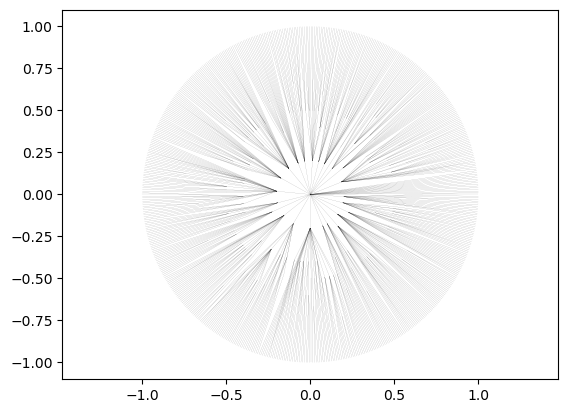

In [184]:
fig, ax = plt.subplots()

for source, target, data in trie.edges(data=True):
    if data["duality"] != "hierarchy":
        continue
    x0, y0 = trie.nodes[source]["position"]
    x1, y1 = trie.nodes[target]["position"]
    ax.plot([x0,x1], [-y0,-y1], color='k', linewidth=0.05)

ax.axis('equal')

In [185]:
def route_via_lca(trie: nx.DiGraph, source, target, skip_lca=True):
    source_to_lca = [source]
    target_to_lca = []

    source_to_root = {""}
    while source != "":
        source_to_root.add(source)
        source = trie.nodes[source]["parent"]
    
    while target not in source_to_root:
        target_to_lca.append(target)
        target = trie.nodes[target]["parent"]
    
    lca = target
    
    while source_to_lca[-1] != lca:
        source_to_lca.append(trie.nodes[source_to_lca[-1]]["parent"])
    
    if skip_lca:
        source_to_lca = source_to_lca[:-1]
    
    source_to_lca.extend(reversed(target_to_lca))
    return source_to_lca

def bundle_adjacency(trie: nx.DiGraph, skip_lca=True):
    for source, target in [(s,t) for s,t,d in trie.edges(data=True) if d["duality"] == "adjacency"]:
        knots = route_via_lca(trie, source, target, skip_lca)
        trie.edges[source, target]["knots"] = knots
        

In [186]:
bundle_adjacency(trie)

In [189]:
def draw_bspline_cubic(path: list[tuple]) -> str:
    """draws a cubic b-spline, with an open knot vector and repeated control points"""
    svg = []
    m = len(path)
    if m < 2:
        raise ValueError("path is less than 2 points long")
    elif m == 2:
        p0 = path[0]
        p1 = path[1]
        svg.append(f'<path d="M {p0[0]:.1f} {p0[1]:.1f} L {p1[0]:.1f} {p1[1]:.1f}"/>')
    else:
        p000 = path[0] # not strictly correct, but works
        p112 = 2/3*path[0] + 1/3*path[1]
        p122 = 1/3*path[0] + 2/3*path[1]
        svg.append(f'<path d="M {p000[0]:.1f} {p000[1]:.1f} C {p112[0]:.1f} {p112[1]:.1f} {p122[0]:.1f} {p122[1]:.1f}')

        for i in range(1, len(path)-1):
            p123 = path[i]
            p234 = path[i+1]
            p223 = 2/3*p123 + 1/3*p234
            p233 = 1/3*p123 + 2/3*p234
            p222 = .5*p122 + .5*p223

            svg.append(f' {p222[0]:.1f} {p222[1]:.1f} S {p233[0]:.1f} {p233[1]:.1f}')
            p122 = p233

        end = path[-1]
        svg.append(f' {end[0]:.1f} {end[1]:.1f}"/>')

    return(''.join(svg))

def draw_svg(
    trie: nx.DiGraph,
    beta=.75,
    width=750,
    border=50,
    linkwidth=.05,
    noderadius=.1,
    linkopacity=1,
    nodeopacity=1,
    fontsize=3,
) -> str:
    scale = width-2*border
    svg = []
    svg.append(f'<svg width="{width:.0f}" height="{width:.0f}" xmlns="http://www.w3.org/2000/svg">')
    svg.append('<style type="text/css">')
    svg.append(f'path{{stroke:black;stroke-width:{scale*linkwidth:.3f};stroke-opacity:{linkopacity:.3f};stroke-linecap:round;fill:transparent}}')
    svg.append(f'circle{{r:{scale*noderadius:.3f};stroke-width:0;fill-opacity:{nodeopacity:.3f}}}')
    svg.append('</style>')
    
    # add white background
    svg.append('<rect width="100%" height="100%" fill="white"/>')
    
    
    x_min, y_min = 2 * [float("inf")]
    x_max, y_max = 2 * [-float("inf")]
    for node, data in trie.nodes(data=True):
        x_min = min(x_min, data["position"][0])
        y_min = min(y_min, data["position"][1])
        x_max = max(x_max, data["position"][0])
        y_max = max(y_max, data["position"][1])
    
    # want to scale everything to 0-1 first
    unit_scale = 1 / max(x_max - x_min, y_max - y_min)
    unit_trans = -np.array([x_min, y_min])
    
    # move to (0,0)-(1,1) then expand to square
    place_node = lambda x: (x + unit_trans) * unit_scale * scale + np.array([border, border])
    
    # draw splines
    for source, target, data in trie.edges(data=True):
        if data["duality"] != "adjacency" or source == target:
            continue
            
        spline = place_node(np.array([trie.nodes[knot]["position"] for knot in data["knots"]]))
        
        # straighten with beta as per (Holten, 2006)
        for i in range(1, len(spline)-1):
            spline[i] = beta*spline[i] + (1-beta) * (spline[0] + (i/(len(spline)-1))*(spline[-1]-spline[0]))
            
        svg.append(draw_bspline_cubic(spline))
        
    for node, data in trie.nodes(data=True):
        if data.get("leaf", False):
            zi_position = place_node(data["position"])
            svg.append(f'<text x="{zi_position[0]}" y="{zi_position[1]}" text-anchor="middle" text-align="center" font-size="{fontsize}">{node}</text>')

    svg.append('</svg>')

    return '\n'.join(svg)

In [190]:
from cairosvg import svg2png

svg = draw_svg(trie, beta=0.75, linkwidth=0.003, linkopacity=0.2, noderadius=0.012)
with open(f'bundled.svg', 'w') as f:
    print(svg, file=f)
svg2png(bytestring=svg, write_to=f'bundled.png', dpi=400)